In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8" # 0.9 causes too much lag. 
os.environ['MUJOCO_GL'] = 'egl'

import functools

import jax.numpy as jp
import numpy as np
import jax
print("JAX Device:", jax.devices())
from jax import config # Analytical gradients work much better with double precision.
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', 'high')

from mujoco_playground import registry
from mujoco_playground import wrapper
from mujoco_playground.config import locomotion_params

from brax.training.agents.apg import train as apg
from brax.training.agents.apg import networks as apg_networks

from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo

from brax.io import model

import matplotlib.pyplot as plt
from IPython.display import HTML, clear_output
from datetime import datetime
import mediapy as media

env = registry.load("AnymalTrot")
eval_env = registry.load("AnymalTrot")
env_name = "AnymalTrot"

JAX Device: [CudaDevice(id=0)]


In [2]:
def render_rollout(reset_fn, step_fn, env, inference_fn, n_step, render_every, seed=0):
    rng = jax.random.PRNGKey(seed)
    state = reset_fn(rng)
    rollout_list = [state]
    for i in range(n_step):
        act_rng, rng = jax.random.split(rng)
        action, _ = inference_fn(state.obs, act_rng)
        state = step_fn(state, action)
        rollout_list.append(state)
    traj = rollout_list[::render_every]
    fps = 1.0 / (env.dt * render_every)
    frames = env.render(traj, height=480, width=640)
    media.show_video(frames, fps=fps, loop=True)

    return frames

In [3]:
print(env.lowers)
print(env.uppers)

[-0.72    -9.42478 -9.42478 -0.49    -9.42478 -9.42478 -0.72    -9.42478
 -9.42478 -0.49    -9.42478 -9.42478]
[0.49    9.42478 9.42478 0.72    9.42478 9.42478 0.49    9.42478 9.42478
 0.72    9.42478 9.42478]


In [4]:
step_fn = jax.jit(env.step)
reset_fn = jax.jit(env.reset)

# state = reset_fn(jax.random.PRNGKey(42))
# state = step_fn(state, jp.zeros(env.action_size))

In [5]:
def generate_test_actions(action_dim, steps=20, seed=0):
    rng = np.random.default_rng(seed)
    actions = []

    # 1. 零动作
    actions.append(np.zeros(action_dim))

    # 2. 小幅随机动作
    for _ in range(5):
        actions.append(0.1 * rng.standard_normal(action_dim))

    # 3. 周期性动作（正弦波）
    for t in range(5):
        a = 0.3 * np.sin(2 * np.pi * t / 5) * np.ones(action_dim)
        actions.append(a)

    # 4. 极端动作（边界值）
    actions.append(np.ones(action_dim))    # max
    actions.append(-np.ones(action_dim))   # min

    # 5. 混合：随机 + 正弦
    for t in range(steps - len(actions)):
        a = 0.2 * np.sin(2 * np.pi * t / 10) * np.ones(action_dim)
        a += 0.1 * rng.standard_normal(action_dim)
        actions.append(a)

    return np.array(actions)

# 用法
actions = generate_test_actions(env.action_size, steps=20, seed=42)
print(actions.shape)  # (20, action_dim)
print(actions)      # 打印生成的动作序列


(20, 12)
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.03047171 -0.10399841  0.07504512  0.09405647 -0.19510352 -0.13021795
   0.01278404 -0.03162426 -0.00168012 -0.08530439  0.0879398   0.07777919]
 [ 0.00660307  0.11272412  0.04675093 -0.08592925  0.03687508 -0.09588826
   0.08784503 -0.00499259 -0.01848624 -0.06809295  0.12225413 -0.01545295]
 [-0.04283278 -0.03521336  0.05323092  0.03654441  0.04127326  0.0430821
   0.21416476 -0.0406415  -0.05122427 -0.08137727  0.06159794  0.11289723]
 [-0.01139475 -0.08401565 -0.08244812  0.06505928  0.07432542  0.05431543
  -0.06655097  0.02321613  0.01166858  0.02186886  0.08714288  0.02235955]
 [ 0.06789136  0.00675791  0.02891194  0.06312882 -0.14571558 -0.03196712
  -0.04703727 -0.06388778 -0.02751423  0.14949413 -0.08658311  0.09682784]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0

In [6]:
import time

def rollout(reset_fn, step_fn, actions, seed=0):
    """
    Rollout the TrotAnymal environment using a sequence of actions.
    Args:
        env: TrotAnymal instance
        actions: jp.array of shape [episode_length, action_dim]
        seed: random seed for reset
    Returns:
        states: list of mjx_env.State objects
    """
    rng = jax.random.PRNGKey(seed)
    state = reset_fn(rng)
    states = [state]
    print("start")
    for action in actions:
        start = time.time()
        state = step_fn(state, action)
        states.append(state)
        print("step cost:", time.time() - start)
    return states

states = rollout(reset_fn, step_fn, jp.array(actions), seed=42)

start
step cost: 53.269052267074585
step cost: 54.94437336921692
step cost: 0.019809961318969727
step cost: 0.019693851470947266
step cost: 0.021040678024291992
step cost: 0.01987457275390625
step cost: 0.03868460655212402
step cost: 0.045294761657714844
step cost: 0.02472376823425293
step cost: 0.025123119354248047
step cost: 0.03514885902404785
step cost: 0.023023366928100586
step cost: 0.02373051643371582
step cost: 0.05924272537231445
step cost: 0.10921454429626465
step cost: 0.04318118095397949
step cost: 0.021657228469848633
step cost: 0.046950578689575195
step cost: 0.04507899284362793
step cost: 0.027825593948364258


In [7]:
qpos_list = [state.data.qpos for state in states]
qvel_list = [state.data.qvel for state in states]
reward_list = [state.reward for state in states]
done_list = [state.done for state in states]

# 将列表转换为 NumPy 数组
qpos_array = np.stack(qpos_list)
qvel_array = np.stack(qvel_list)
reward_array = np.stack(reward_list)
done_array = np.stack(done_list)

print("qpos_array shape:", qpos_array.shape)
print("qvel_array shape:", qvel_array.shape)
print("reward_array shape:", reward_array.shape)
print("done_array shape:", done_array.shape)

# np.savez_compressed(
#     'test_trajectory_data.npz',
#     qpos=qpos_array,
#     qvel=qvel_array,
#     reward=reward_array,
#     done=done_array
# )

qpos_array shape: (21, 19)
qvel_array shape: (21, 18)
reward_array shape: (21,)
done_array shape: (21,)


## training APG

In [8]:
apg_params = locomotion_params.brax_apg_config("AnymalTrot")
print(apg_params)

action_repeat: 1
episode_length: 240
horizon_length: 32
learning_rate: 0.0001
max_gradient_norm: 1000000000.0
network_factory:
  hidden_layer_sizes: !!python/tuple
  - 256
  - 128
normalize_observations: true
num_envs: 64
num_eval_envs: 64
num_evals: 11
policy_updates: 499
use_float64: true



In [9]:
apg_training_params = dict(apg_params)
network_factory = apg_networks.make_apg_networks
if "network_factory" in apg_params:
    del apg_training_params["network_factory"]
    network_factory = functools.partial(
        apg_networks.make_apg_networks, 
        **apg_params.network_factory)

train_fn = functools.partial(
    apg.train, **dict(apg_training_params),
    network_factory=network_factory)

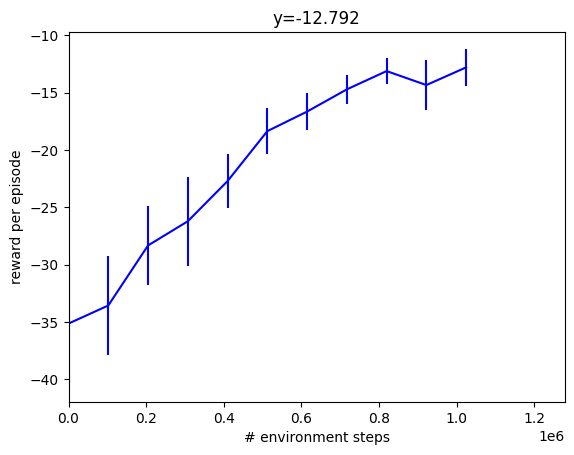

time to jit: 0:01:20.045534
time to train: 0:10:38.333300


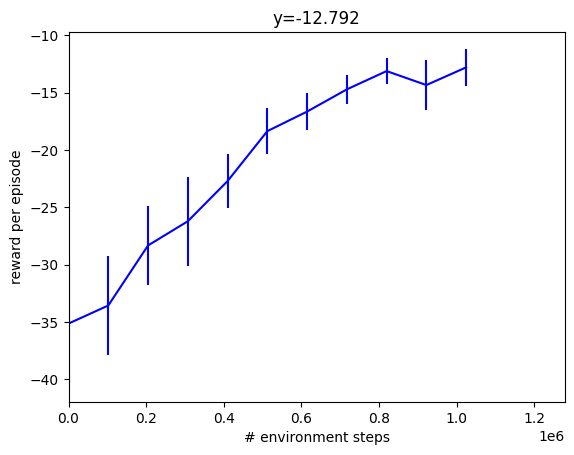

In [10]:
from datetime import datetime
x_data_apg = []
y_data_apg = []
ydataerr_apg = []
times_apg = [datetime.now()]

num_timesteps = apg_params["policy_updates"] * apg_params["horizon_length"] * apg_params["num_envs"] * apg_params["action_repeat"]
updates_per_epoch = round(apg_params["policy_updates"] / max(apg_params["num_evals"] - 1, 1))
scale_it = updates_per_epoch * apg_params["horizon_length"] * apg_params["num_envs"] * apg_params["action_repeat"]

def progress_apg(num_steps, metrics):
    # clear_output(wait=True)

    times_apg.append(datetime.now())
    x_data_apg.append(num_steps * scale_it)
    y_data_apg.append(metrics["eval/episode_reward"])
    ydataerr_apg.append(metrics["eval/episode_reward_std"])

    # plt.xlim([0, num_timesteps * 1.25])
    # plt.xlabel("# environment steps")
    # plt.ylabel("reward per episode")
    # plt.title(f"y={y_data_apg[-1]:.3f}")
    # plt.errorbar(x_data_apg, y_data_apg, yerr=ydataerr_apg, color="blue")

    # display(plt.gcf())

# def progress(it, metrics):
#     times.append(datetime.now())
#     x_data.append(it)
#     y_data.append(metrics['eval/episode_reward'])
#     ydataerr.append(metrics['eval/episode_reward_std'])

make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=eval_env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
    progress_fn=progress_apg
)

# plt.errorbar(x_data, y_data, yerr=ydataerr)
plt.xlim([0, num_timesteps * 1.25])
plt.xlabel("# environment steps")
plt.ylabel("reward per episode")
plt.title(f"y={y_data_apg[-1]:.3f}")
plt.errorbar(x_data_apg, y_data_apg, yerr=ydataerr_apg, color="blue")
display(plt.gcf())

print(f"time to jit: {times_apg[1] - times_apg[0]}")
print(f"time to train: {times_apg[-1] - times_apg[1]}")

In [11]:
demo_env = registry.load("AnymalTrot")
demo_step_fn = jax.jit(demo_env.step)
demo_reset_fn = jax.jit(demo_env.reset)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

frames = render_rollout(
    demo_reset_fn, demo_step_fn, demo_env, 
    jit_inference_fn, n_step=200, render_every=3, seed=1)

100%|██████████| 67/67 [00:00<00:00, 144.28it/s]


In [12]:
from brax.io import model
model_path = '/tmp/trotting_apg_2hz_policy'
model.save_params(model_path, params)

## training PPO

In [13]:
ppo_params = locomotion_params.brax_ppo_config("AnymalTrot")
ppo_training_params = dict(ppo_params)
ppo_network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
    del ppo_training_params["network_factory"]
    ppo_network_factory = functools.partial(
        ppo_networks.make_ppo_networks,
        **ppo_params.network_factory
    )

x_data_ppo = []
y_data_ppo = []
ydataerr_ppo = []
times_ppo = [datetime.now()]

def progress_ppo(num_steps, metrics):
    # clear_output(wait=True)

    times_ppo.append(datetime.now())
    x_data_ppo.append(num_steps)
    y_data_ppo.append(metrics["eval/episode_reward"])
    ydataerr_ppo.append(metrics["eval/episode_reward_std"])

    # plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
    # plt.xlabel("# environment steps")
    # plt.ylabel("reward per episode")
    # plt.title(f"y={y_data_ppo[-1]:.3f}")
    # plt.errorbar(x_data_ppo, y_data_ppo, yerr=ydataerr_ppo, color="blue")

    # display(plt.gcf())

train_ppo_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=ppo_network_factory,
    progress_fn=progress_ppo
)

time to jit: 0:01:54.933324
time to train: 0:14:39.402123


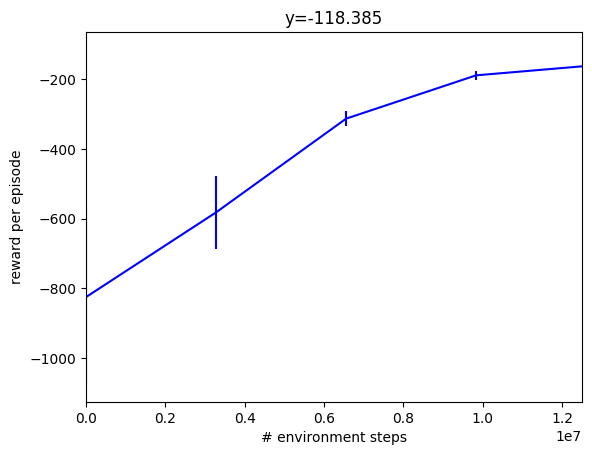

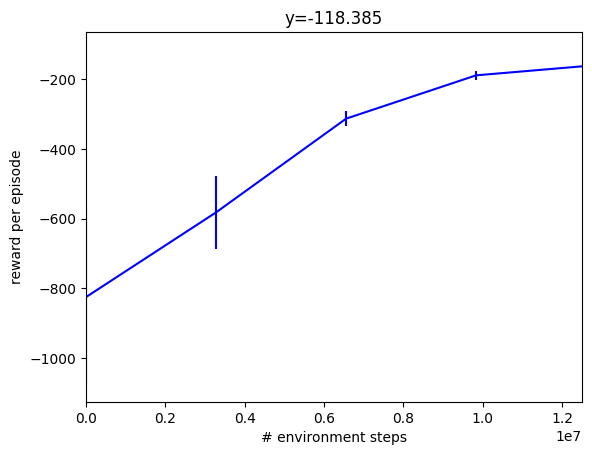

In [14]:
make_ppo_inference_fn, inference_ppo_params, metrics = train_ppo_fn(
    environment=env,
    eval_env=eval_env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times_ppo[1] - times_ppo[0]}")
print(f"time to train: {times_ppo[-1] - times_ppo[1]}")

plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
plt.xlabel("# environment steps")
plt.ylabel("reward per episode")
plt.title(f"y={y_data_ppo[-1]:.3f}")
plt.errorbar(x_data_ppo, y_data_ppo, yerr=ydataerr_ppo, color="blue")
display(plt.gcf())

In [15]:
demo_env = registry.load("AnymalTrot")
demo_step_fn = jax.jit(demo_env.step)
demo_reset_fn = jax.jit(demo_env.reset)
jit_inference_ppo_fn = jax.jit(make_ppo_inference_fn(inference_ppo_params, deterministic=True))

frames = render_rollout(
    demo_reset_fn, demo_step_fn, demo_env, 
    jit_inference_ppo_fn, n_step=200, render_every=3, seed=1)

100%|██████████| 67/67 [00:00<00:00, 149.36it/s]
